In [89]:
from __future__ import print_function, division
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
import os
import cv2
from skimage import transform
from imageio import imread


In [104]:
#Hyperparameters

#Output Shape
resolution = (128,128)

# Input shape
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)

# Size of Patch for PatchGAN
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters for G and D
filters_gen = 64

#Optimizer for the GAN.
optimizer = Adam(0.00015, 0.5)

# def load_images(dataset,batch_size):
#     chance = np.random.random()
#     path = glob('cityscapes/train/*')
#     images = np.random.choice(path, size=batch_size)
#     img_real = []
#     img_labelled = []

#     for imagepath in images:
#         img = cv2.imread(imagepath)
#         width = img.shape[1]
#         width = width//2
#         real_img, labelled_img = img[:, width:, :],img[:, :width, :]
#         real_img,labelled_img = transform.resize(real_img, resolution),transform.resize(labelled_img, resolution)
#         if (chance<0.5):
#             real_img = np.fliplr(real_img)
#             labelled_img = np.fliplr(labelled_img)
#         img_real.append(real_img)
#         img_labelled.append(labelled_img)
#     return np.array(img_labelled),np.array(img_real)

def load_images(dataset,batch_size,epoch):
    chance = np.random.random()
    path = glob('cityscapes/train/*')
#     images = np.random.choice(path, size=batch_size)
    images = path[epoch*batch_size:(epoch+1)*batch_size]
    img_real = []
    img_labelled = []
    for imagepath in images:
        img = imread(imagepath)
        width = img.shape[1]
        width = width//2
        real_img, labelled_img = img[:, width:, :],img[:, :width, :]
        real_img,labelled_img = transform.resize(real_img, resolution),transform.resize(labelled_img, resolution)
        if (chance<0.5):
            real_img = np.fliplr(real_img)
            labelled_img = np.fliplr(labelled_img)
        img_real.append(real_img)
        img_labelled.append(labelled_img)
    if(dataset=='55'):
        return np.array(img_real), np.array(img_labelled)
    return np.array(img_labelled), np.array(img_real)

# REMEBER! - arr1(A) is the actual truth. arr2(B) is the labelled graphical image

# for batch_i, (imgs_A, imgs_B) in enumerate(load_images(1,2)):
#     print("hey")
arr1,arr2 = load_images('1',32,12)
# arr1.shape

/data/anaconda/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


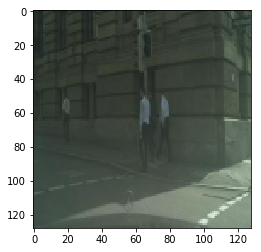

In [105]:
plt.imshow(arr1[7])
# path = glob('facades/train/*')
# len(path)
# arr1.shape

In [106]:
def new_generator():
    layer0 = Input(shape=img_shape,name="input")
    layer1 = Conv2D(filters_gen, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(layer0)
    bd = BatchNormalization(momentum=0.8)(layer1)
    layer2 = Conv2D(filters_gen*2, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer2)
    layer3 = Conv2D(filters_gen*4, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer3)
    layer4 = Conv2D(filters_gen*8, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer4)
    layer5 = Conv2D(filters_gen*8, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer5)
    layer6 = Conv2D(filters_gen*8, kernel_size=4,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(bd)
    bd = BatchNormalization(momentum=0.8)(layer6)
    dropout = Dropout(0.10)(bd)
    layer7 = Conv2D(filters_gen*8, kernel_size=2,strides = 2,activation = LeakyReLU(alpha=0.2),padding='same')(dropout)
    bd = BatchNormalization(momentum=0.8)(layer7)
    def deconv2d(prev_layer, skip_input, filters):
        temp = UpSampling2D(size=2)(prev_layer)
        temp = Conv2D(filters, kernel_size=4, strides=1, padding='same', activation='relu')(temp)
        temp = BatchNormalization(momentum=0.6)(temp)
        temp = Concatenate()([temp, skip_input])
        return temp
    
    u_layer1 = deconv2d(bd, layer6, filters_gen*8)
    u_layer2 = deconv2d(u_layer1, layer5, filters_gen*8)
    u_layer3 = deconv2d(u_layer2, layer4, filters_gen*8)
    u_layer4 = deconv2d(u_layer3, layer3, filters_gen*4)
    dropout = Dropout(0.10)(u_layer4)
    u_layer5 = deconv2d(dropout, layer2, filters_gen*2)
    u_layer6 = deconv2d(u_layer5, layer1, filters_gen)
    u_layer7 = UpSampling2D(size=2)(u_layer6)
    u_layer0 = Conv2D(channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u_layer7)
    return Model(layer0,u_layer0,name="Generator")


def new_discriminator():
    def d_layer(prev_layer, filters):
        temp = Conv2D(filters, kernel_size=4, strides=2, padding='same')(prev_layer)
        temp = LeakyReLU(alpha=0.2)(temp)
        return temp

    layer0_A = Input(shape=img_shape)
    layer0_B = Input(shape=img_shape)
    combined_input = Concatenate(axis=-1)([layer0_A, layer0_B])
    layer1 = d_layer(combined_input, filters_gen)
    layer2 = d_layer(layer1, filters_gen*2)
    layer3 = d_layer(layer2, filters_gen*4)
    layer4 = d_layer(layer3, filters_gen*8)
    dropout = Dropout(0.20)(layer4)
    layer5 = Conv2D(1, kernel_size=4, strides=1, padding='same')(dropout)
    return Model([layer0_A, layer0_B], layer5,name="Discriminator")

# heaven = new_discriminator()
# heaven.summary()


In [107]:
'''
1. Two images as input.
2. One image goes to generator
3. Two images go to the discriminator as input
4. We freeze the discriminator weights
5. Create GAN with both models. Inputs - B (Labelled Graphical) as earlier and outputs (A - Ground Truth) as earlier
'''
#<---Since the model is being compiled already here, 
# the flag later of trainable = False does not affect it.--->
d = new_discriminator()
d.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])


g = new_generator()

input_image_A = Input(shape = img_shape)
input_image_B = Input(shape = img_shape)

fake_image_B = g(input_image_B)
validity = d([fake_image_B,input_image_B])

#THIS ONLY STOPS THE TRAINING OF THE DISCRIMINATOR IN THE GAN. IT WILL STILL TRAIN WHEN INVOKED AS JUST D.
d.trainable = False

gan = Model(inputs=[input_image_A,input_image_B],outputs = [validity,fake_image_B],name="GAN")

gan.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)
gan.summary()

/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Generator (Model)               (None, 128, 128, 3)  38697859    input_40[0][0]                   
__________________________________________________________________________________________________
Discriminator (Model)           (None, 8, 8, 1)      2767809     Generator[1][0]                  
                                                                 input_40[0][0]                   
Total params: 41,465,668
Trainable params: 38,688,899
Non-trainable params: 2,776,769
__________________________________________________________________________________________________


In [110]:
def plot_img():
    truth,labelled = load_images(1,1,1)
    predict = g.predict(labelled)
    plt.imshow(predict[0])
    plt.show()
    plt.imshow(truth[0])
    plt.show()

def train(epochs,batch_size):
    valid_scores = np.ones((batch_size,disc_patch[0],disc_patch[1],disc_patch[2]))
    fake_scores = np.zeros((batch_size,disc_patch[0],disc_patch[1],disc_patch[2]))
    for j in range(epochs):
        print("Epoch -",j+1)
        start = datetime.datetime.now()
        for i in range(0,85):
# begin
            images_A,images_B = load_images(1,batch_size,i)
            fake_images = g.predict(images_B)

            #Discriminator losses
            d_loss_real = d.train_on_batch([images_A,images_B],valid_scores)
            d_loss_fake = d.train_on_batch([fake_images,images_B],fake_scores)
            avg_d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            #GAN losses
            gan_loss = gan.train_on_batch([images_A,images_B],[valid_scores,images_A])
# end
        print("Discriminator Loss = ",avg_d_loss[0], "Accuracy =",avg_d_loss[1]*100)
        print("GAN Loss = ",gan_loss[0])
        end = start_time = datetime.datetime.now()
        print("Time Elapsed",end-start,"\n")
        if(j%10==0):
            plot_img()
#     return avg_d_loss, gan_loss


Epoch - 1


/data/anaconda/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/data/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Discriminator Loss =  0.2710479 Accuracy = 46.38671875
GAN Loss =  9.86563
Time Elapsed 0:02:30.221823 



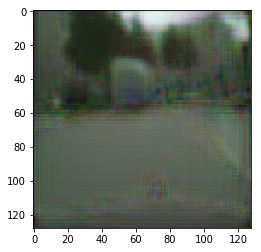

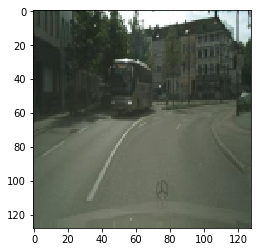

Epoch - 2
Discriminator Loss =  0.23621847 Accuracy = 58.1787109375
GAN Loss =  9.717784
Time Elapsed 0:02:31.030824 

Epoch - 3
Discriminator Loss =  0.24970144 Accuracy = 52.294921875
GAN Loss =  9.469382
Time Elapsed 0:02:30.958663 

Epoch - 4
Discriminator Loss =  0.18631303 Accuracy = 71.8994140625
GAN Loss =  9.495265
Time Elapsed 0:02:30.975548 

Epoch - 5
Discriminator Loss =  0.1583606 Accuracy = 78.564453125
GAN Loss =  9.530921
Time Elapsed 0:02:31.125613 

Epoch - 6
Discriminator Loss =  0.14076756 Accuracy = 83.935546875
GAN Loss =  9.461644
Time Elapsed 0:02:30.911596 

Epoch - 7
Discriminator Loss =  0.14402601 Accuracy = 82.1044921875
GAN Loss =  9.490177
Time Elapsed 0:02:30.890620 

Epoch - 8
Discriminator Loss =  0.13956362 Accuracy = 82.4462890625
GAN Loss =  9.852476
Time Elapsed 0:02:30.720627 

Epoch - 9
Discriminator Loss =  0.13361973 Accuracy = 84.6923828125
GAN Loss =  9.182638
Time Elapsed 0:02:30.653896 

Epoch - 10
Discriminator Loss =  0.14525656 Accuracy

In [111]:
# Begin Training
train(10,32)

/data/anaconda/envs/py35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


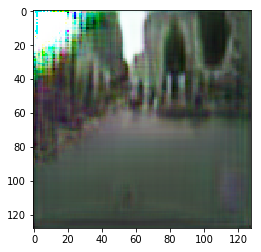

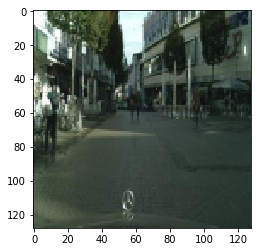

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


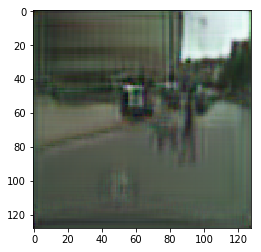

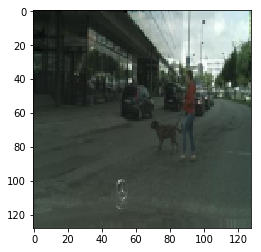

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


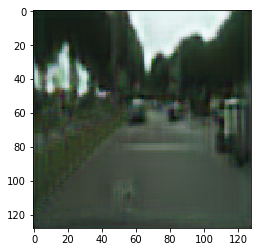

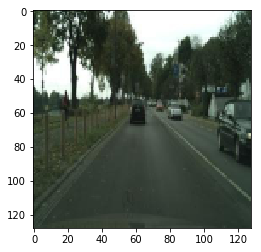

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


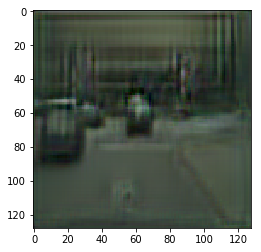

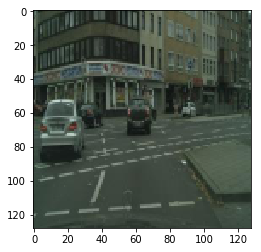

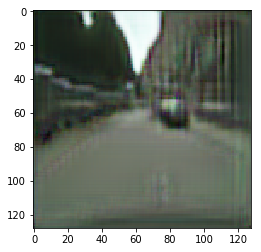

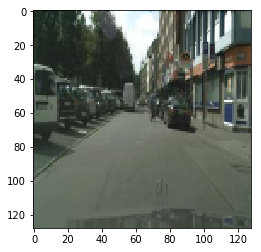

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


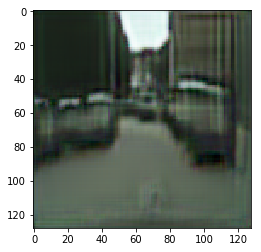

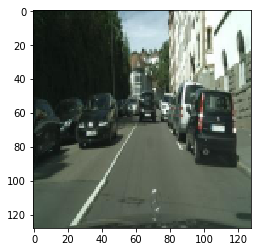

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


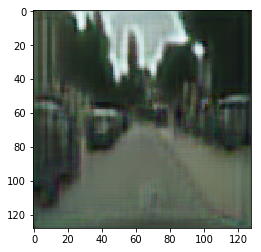

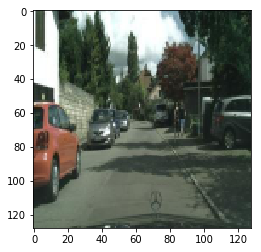

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


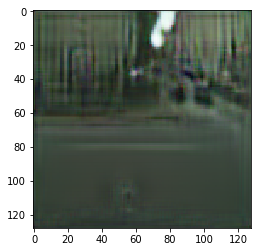

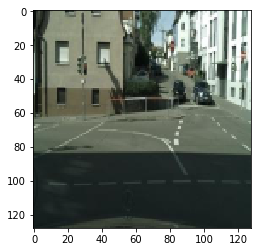

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


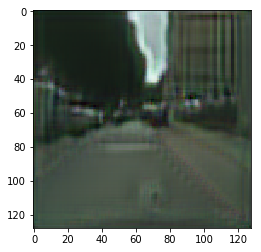

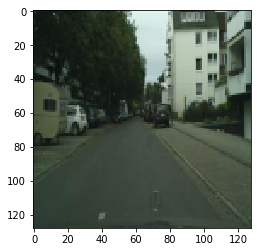

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


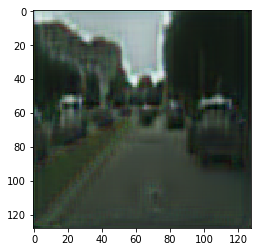

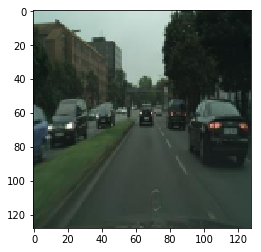

In [115]:
# Testing the GAN

for i in range(0,10):
    truth,labelled = load_images('1',1,i+30)
    predict = g.predict(labelled)
    plt.imshow(predict[0])
    plt.show()
    plt.imshow(truth[0])
    plt.show()



In [116]:
# Saving Model
gan.save_weights('Weights/Cityscapes/GAN_weights.h5')
d.save_weights('Weights/Cityscapes/Discriminator_weights.h5')
